<a href="https://colab.research.google.com/github/de-bo-rah/day2dayML/blob/main/toyproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SENTIMENT ANALYSIS

-- > a form of text classification where we predict the sentiment of a sentence i.e positive, negative, neutral etc
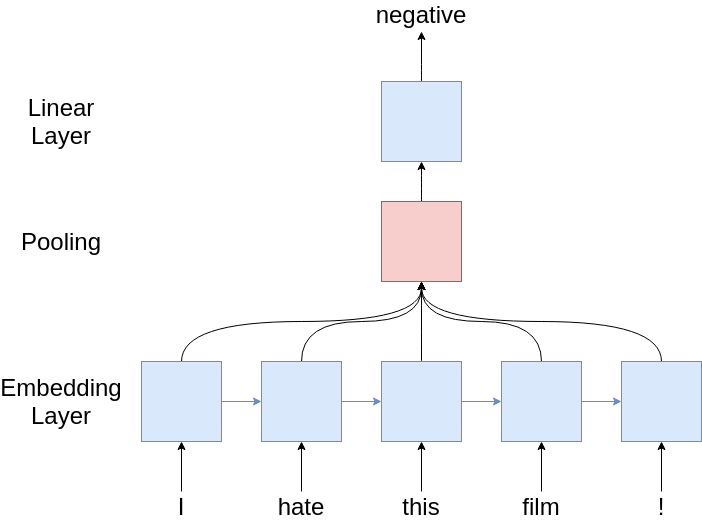

In [18]:
# sbert_imdb_classifier.py

from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import os

# Config
MODEL_NAME = "all-mpnet-base-v2"
BATCH_SIZE = 64
EMB_CACHE_DIR = "embeddings_cache"
os.makedirs(EMB_CACHE_DIR, exist_ok=True)

# 1) Load data
train_ds, test_ds = load_dataset("imdb", split=["train", "test"])
train_texts = train_ds["text"]
train_labels = np.array(train_ds["label"])
test_texts = test_ds["text"]
test_labels = np.array(test_ds["label"])

# 2) Load SBERT model
model = SentenceTransformer(MODEL_NAME)

# 3) Encode texts to embeddings

def encode_and_cache(name, texts, model, batch_size=BATCH_SIZE, cache_dir=EMB_CACHE_DIR):
    fname = os.path.join(cache_dir, f"{name}_{MODEL_NAME.replace('/', '_')}.npy")
    if os.path.exists(fname):
        print(f"Loading embeddings from {fname}")
        return np.load(fname)
    print(f"Encoding {name} set ({len(texts)} examples)...")
    embs = model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    np.save(fname, embs)
    return embs

X_train = encode_and_cache("train", train_texts, model)
X_test  = encode_and_cache("test", test_texts, model)

print("Embedding shapes:", X_train.shape, X_test.shape)

# 4) Train a simple classifier (Logistic Regression)
clf = LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1)
clf.fit(X_train, train_labels)

# 5) Evaluate
preds = clf.predict(X_test)
acc = accuracy_score(test_labels, preds)
f1 = f1_score(test_labels, preds, average="binary")
print("Test accuracy:", acc)
print("Test F1:", f1)
print(classification_report(test_labels, preds))

Loading embeddings from embeddings_cache/train_all-mpnet-base-v2.npy
Encoding test set (25000 examples)...


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Embedding shapes: (25000, 768) (25000, 768)
Test accuracy: 0.89152
Test F1: 0.8922355559087658
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [22]:
# predict for new sentences
sentences = [
    "i love david lynch"
]


embs = model.encode(sentences, batch_size=len(sentences), convert_to_numpy=True)

preds = clf.predict(embs)
probs = clf.predict_proba(embs)[:, 1]   # probability of positive (class=1)

for s, p, prob in zip(sentences, preds, probs):
    label = "positive" if p == 1 else "negative"
    print(f"Text: {s}\nPred: {label}  Prob(pos)={prob:.3f}\n")

Text: i love david lynch
Pred: positive  Prob(pos)=0.998

